# Prediction of Vaccinations for Different Manufacturers (Country-wise)


### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import LSTM,Dense
import seaborn as sns
import scipy
from numpy import array
from scipy import interpolate

### Reading CSV file(Dataset)

In [2]:
data = pd.read_csv("r_vaccinations-by-manufacturer.csv")
df = pd.DataFrame(data)

In [3]:
print(df.head())

  location        date             vaccine  total_vaccinations
0  Austria  2021-01-08     Johnson&Johnson                   0
1  Austria  2021-01-08             Moderna                   0
2  Austria  2021-01-08  Oxford/AstraZeneca                   0
3  Austria  2021-01-08     Pfizer/BioNTech               31096
4  Austria  2021-01-15     Johnson&Johnson                   0


### 1. Country : Romania 

#### 1.1 Manufacturer : Pfizer/BioNTech 

#### Training : Testing = 80:20 i.e. Training dataset = 77 days, Testing dataset = 20 days

Our Training Dataset looks like - 
     location        date          vaccine  total_vaccinations
8932  Romania  2020-12-27  Pfizer/BioNTech                 965
8933  Romania  2020-12-28  Pfizer/BioNTech                2066
8934  Romania  2020-12-29  Pfizer/BioNTech                2778
8935  Romania  2020-12-30  Pfizer/BioNTech                5666
8936  Romania  2020-12-31  Pfizer/BioNTech               10289
...       ...         ...              ...                 ...
9440  Romania  2021-06-27  Pfizer/BioNTech             7063922
9444  Romania  2021-06-28  Pfizer/BioNTech             7077971
9448  Romania  2021-06-29  Pfizer/BioNTech             7092434
9452  Romania  2021-06-30  Pfizer/BioNTech             7106796
9456  Romania  2021-07-01  Pfizer/BioNTech             7119663

[187 rows x 4 columns]
Dimensions of our training dataset is : (187, 4)




Our Testing Dataset looks like - 
     location        date          vaccine  total_vaccinations
9460  Romania  2021-07-02  Pfizer/B

<Figure size 432x288 with 0 Axes>

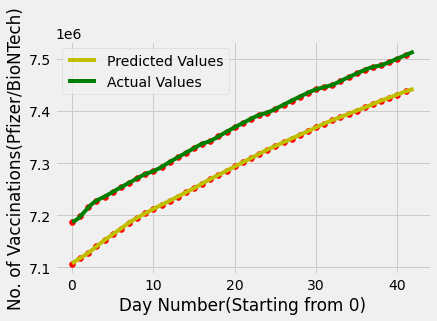

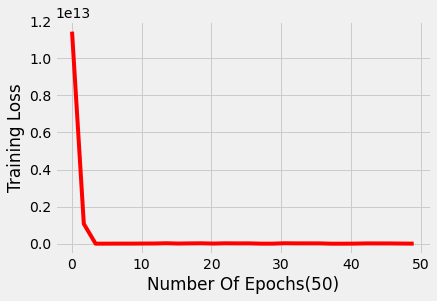

<Figure size 432x288 with 0 Axes>

In [5]:
f_Romania_pfizer = df.loc[df['location'] == 'Romania'].loc[df['vaccine'] == 'Pfizer/BioNTech']

train, test = train_test_split(f_Romania_pfizer, test_size=0.2, shuffle=False)

print("Our Training Dataset looks like - ")
print(train.head(train.shape[0]))
print("Dimensions of our training dataset is : " + str(train.shape))
print('\n\n\n')
print("Our Testing Dataset looks like - ")
print(test.head(test.shape[0]))
print("Dimensions of our testing dataset is : " + str(test.shape))


total_vacc_romania_train = train.loc[:,"total_vaccinations"]
n_train =total_vacc_romania_train.values
#print(n_train)
#print(n_train.shape)


total_vacc_romania_test = test.loc[:,"total_vaccinations"]
n_test =total_vacc_romania_test.values
#print(n_test)
#print(n_test.shape)


# split a univariate sequence into samples (FOR TRAINING DATASET)
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
raw_seq = n_train
# choose a number of time steps
n_steps = 5
# split into samples
X_train, y_train = split_sequence(raw_seq, n_steps)
# summarize the data
#for i in range(len(X_train)):
#    print(X_train[i], y_train[i])

print('\n\n\n\n')
print("Dimensions of Training sequence : " + str(X_train.shape))


# define input sequence
raw_seq = n_test
# choose a number of time steps
n_steps = 5
# split into samples
X_test, y_test = split_sequence(raw_seq, n_steps)
# summarize the data
#for i in range(len(X3)):
#    print(X3[i], y3[i])
print("Dimensions of Testing sequence : " + str(X_test.shape))
print('\n\n\n\n')


# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))



model_rom_2 = Sequential()
model_rom_2.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model_rom_2.add(Dense(20))
model_rom_2.add(Dense(1))
model_rom_2.compile(optimizer='RMSprop', loss='mse',metrics=['accuracy'])

# fit model
history = model_rom_2.fit(X_train, y_train, epochs=50, verbose=0)

y_pred_train = model_rom_2.predict(X_train, verbose=0)
y_pred_test = model_rom_2.predict(X_test, verbose=0)

y_pred_train = y_pred_train.tolist()
y_pred_test = y_pred_test.tolist()

y_test = y_test.tolist()

y_ = []
for i in y_pred_test:
    y_.append(i[0])

merge = tuple(zip(y_,y_test))


acc = []
for i,j in merge:
    acc.append((abs(i-j)/j)*100)

print(acc)
    
a = np.array(acc).mean()
print("Average error percentage over all predictions = " + str(a))

g = X_test.shape[0]

x = [i for i in range(0,g)]

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.scatter(x,y_,color = 'r')
plt.scatter(x,y_test,color = 'r')
x_new = np.linspace(0,g,1000)
an = scipy.interpolate.make_interp_spline(x,y_)
an1 = scipy.interpolate.make_interp_spline(x,y_test)
y_new = an(x_new)
y_new1 = an1(x_new)
plt.plot(x_new, y_new,label = 'Predicted Values', color = 'y')
plt.plot(x_new, y_new1,label = 'Actual Values',color = 'g')
plt.legend()
plt.xlabel("Day Number(Starting from 0)")
plt.ylabel("No. of Vaccinations(Pfizer/BioNTech)")
plt.figure()

acc = history.history['loss']
ep = range(len(acc))
x_new2 = np.linspace(0, 49, 30)
a_BSpline2 = interpolate.make_interp_spline(ep,acc)
y_new2 = a_BSpline2(x_new2)
plt.plot(x_new2,y_new2,'r', label='Training Loss' )
plt.xlabel("Number Of Epochs(50)")
plt.ylabel("Training Loss")
plt.figure()

### 1. 2 Manufacturer : Oxford/AstraZeneca

#### Training : Testing = 80:20 i.e. Training dataset = 77 days, Testing dataset = 20 days

Our Training Dataset looks like - 
     location        date             vaccine  total_vaccinations
8994  Romania  2021-02-15  Oxford/AstraZeneca                6812
8997  Romania  2021-02-16  Oxford/AstraZeneca               13624
9000  Romania  2021-02-17  Oxford/AstraZeneca               22956
9003  Romania  2021-02-18  Oxford/AstraZeneca               31858
9006  Romania  2021-02-19  Oxford/AstraZeneca               41296
...       ...         ...                 ...                 ...
9479  Romania  2021-07-07  Oxford/AstraZeneca              841212
9483  Romania  2021-07-08  Oxford/AstraZeneca              841533
9487  Romania  2021-07-10  Oxford/AstraZeneca              841932
9491  Romania  2021-07-11  Oxford/AstraZeneca              842208
9495  Romania  2021-07-12  Oxford/AstraZeneca              842416

[147 rows x 4 columns]
Dimensions of our training dataset is : (147, 4)




Our Testing Dataset looks like - 
     location        date             vaccine  total_vaccinati

<Figure size 432x288 with 0 Axes>

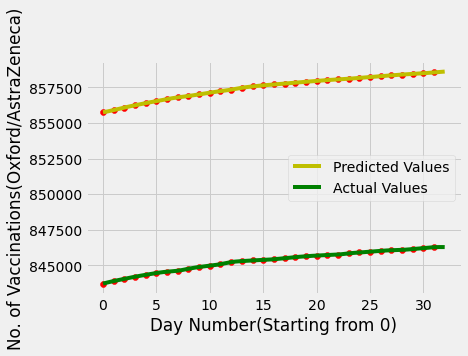

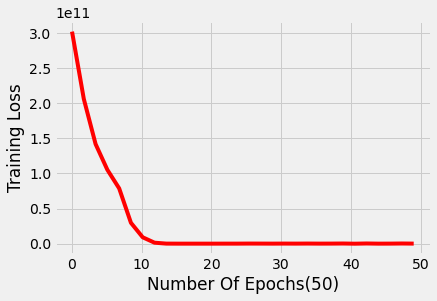

<Figure size 432x288 with 0 Axes>

In [10]:
f_Romania_oxford = df.loc[df['location'] == 'Romania'].loc[df['vaccine'] == 'Oxford/AstraZeneca']

train, test = train_test_split(f_Romania_oxford, test_size=0.2, shuffle=False)

print("Our Training Dataset looks like - ")
print(train.head(train.shape[0]))
print("Dimensions of our training dataset is : " + str(train.shape))
print('\n\n\n')
print("Our Testing Dataset looks like - ")
print(test.head(test.shape[0]))
print("Dimensions of our testing dataset is : " + str(test.shape))


total_vacc_romania_train = train.loc[:,"total_vaccinations"]
n_train =total_vacc_romania_train.values
#print(n_train)
#print(n_train.shape)


total_vacc_romania_test = test.loc[:,"total_vaccinations"]
n_test =total_vacc_romania_test.values
#print(n_test)
#print(n_test.shape)


# split a univariate sequence into samples (FOR TRAINING DATASET)
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
raw_seq = n_train
# choose a number of time steps
n_steps = 5
# split into samples
X_train, y_train = split_sequence(raw_seq, n_steps)
# summarize the data
#for i in range(len(X_train)):
#    print(X_train[i], y_train[i])

print('\n\n\n\n')
print("Dimensions of Training sequence : " + str(X_train.shape))


# define input sequence
raw_seq = n_test
# choose a number of time steps
n_steps = 5
# split into samples
X_test, y_test = split_sequence(raw_seq, n_steps)
# summarize the data
#for i in range(len(X3)):
#    print(X3[i], y3[i])
print("Dimensions of Testing sequence : " + str(X_test.shape))
print('\n\n\n\n')


# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))



model_rom_2 = Sequential()
model_rom_2.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model_rom_2.add(Dense(20))
model_rom_2.add(Dense(1))
model_rom_2.compile(optimizer='RMSprop', loss='mse',metrics=['accuracy'])

# fit model
history = model_rom_2.fit(X_train, y_train, epochs=50, verbose=0)

y_pred_train = model_rom_2.predict(X_train, verbose=0)
y_pred_test = model_rom_2.predict(X_test, verbose=0)

y_pred_train = y_pred_train.tolist()
y_pred_test = y_pred_test.tolist()

y_test = y_test.tolist()

y_ = []
for i in y_pred_test:
    y_.append(i[0])

merge = tuple(zip(y_,y_test))


acc = []
for i,j in merge:
    acc.append((abs(i-j)/j)*100)

print(acc)
    
a = np.array(acc).mean()
print("Average error percentage over all predictions = " + str(a))

g = X_test.shape[0]

x = [i for i in range(0,g)]

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.scatter(x,y_,color = 'r')
plt.scatter(x,y_test,color = 'r')
x_new = np.linspace(0,g,1000)
an = scipy.interpolate.make_interp_spline(x,y_)
an1 = scipy.interpolate.make_interp_spline(x,y_test)
y_new = an(x_new)
y_new1 = an1(x_new)
plt.plot(x_new, y_new,label = 'Predicted Values', color = 'y')
plt.plot(x_new, y_new1,label = 'Actual Values',color = 'g')
plt.legend()
plt.xlabel("Day Number(Starting from 0)")
plt.ylabel("No. of Vaccinations(Oxford/AstraZeneca)")
plt.figure()

acc = history.history['loss']
ep = range(len(acc))
x_new2 = np.linspace(0, 49, 30)
a_BSpline2 = interpolate.make_interp_spline(ep,acc)
y_new2 = a_BSpline2(x_new2)
plt.plot(x_new2,y_new2,'r', label='Training Loss' )
plt.xlabel("Number Of Epochs(50)")
plt.ylabel("Training Loss")
plt.figure()

### 1.3 Manufacturer : Moderna

#### Training : Testing = 80:20 i.e. Training dataset = 77 days, Testing dataset = 20 days

Our Training Dataset looks like - 
     location        date  vaccine  total_vaccinations
8971  Romania  2021-02-04  Moderna                6443
8973  Romania  2021-02-05  Moderna               14944
8975  Romania  2021-02-06  Moderna               23087
8977  Romania  2021-02-07  Moderna               31026
8979  Romania  2021-02-08  Moderna               35454
...       ...         ...      ...                 ...
9474  Romania  2021-07-06  Moderna              714281
9478  Romania  2021-07-07  Moderna              714783
9482  Romania  2021-07-08  Moderna              715335
9486  Romania  2021-07-10  Moderna              716250
9490  Romania  2021-07-11  Moderna              717132

[151 rows x 4 columns]
Dimensions of our training dataset is : (151, 4)




Our Testing Dataset looks like - 
     location        date  vaccine  total_vaccinations
9494  Romania  2021-07-12  Moderna              717443
9498  Romania  2021-07-13  Moderna              717844
9502  Romania  2021-07-14  Mo

<Figure size 432x288 with 0 Axes>

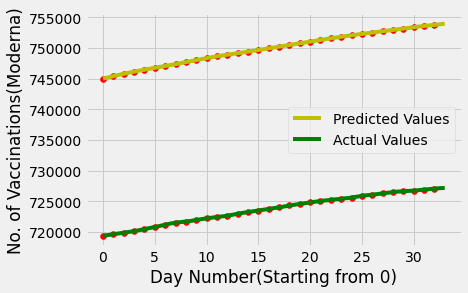

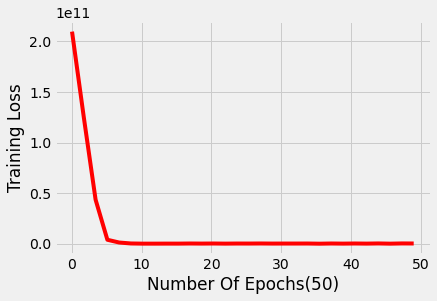

<Figure size 432x288 with 0 Axes>

In [22]:
f_Romania_moderna = df.loc[df['location'] == 'Romania'].loc[df['vaccine'] == 'Moderna']

train, test = train_test_split(f_Romania_moderna, test_size=0.2, shuffle=False)

print("Our Training Dataset looks like - ")
print(train.head(train.shape[0]))
print("Dimensions of our training dataset is : " + str(train.shape))
print('\n\n\n')
print("Our Testing Dataset looks like - ")
print(test.head(test.shape[0]))
print("Dimensions of our testing dataset is : " + str(test.shape))


total_vacc_romania_train = train.loc[:,"total_vaccinations"]
n_train =total_vacc_romania_train.values
#print(n_train)
#print(n_train.shape)


total_vacc_romania_test = test.loc[:,"total_vaccinations"]
n_test =total_vacc_romania_test.values
#print(n_test)
#print(n_test.shape)


# split a univariate sequence into samples (FOR TRAINING DATASET)
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
raw_seq = n_train
# choose a number of time steps
n_steps = 5
# split into samples
X_train, y_train = split_sequence(raw_seq, n_steps)
# summarize the data
#for i in range(len(X_train)):
#    print(X_train[i], y_train[i])

print('\n\n\n\n')
print("Dimensions of Training sequence : " + str(X_train.shape))


# define input sequence
raw_seq = n_test
# choose a number of time steps
n_steps = 5
# split into samples
X_test, y_test = split_sequence(raw_seq, n_steps)
# summarize the data
#for i in range(len(X3)):
#    print(X3[i], y3[i])
print("Dimensions of Testing sequence : " + str(X_test.shape))
print('\n\n\n\n')


# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))



model_rom_2 = Sequential()
model_rom_2.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model_rom_2.add(Dense(20))
model_rom_2.add(Dense(1))
model_rom_2.compile(optimizer='RMSprop', loss='mse',metrics=['accuracy'])

# fit model
history = model_rom_2.fit(X_train, y_train, epochs=50, verbose=0)

y_pred_train = model_rom_2.predict(X_train, verbose=0)
y_pred_test = model_rom_2.predict(X_test, verbose=0)

y_pred_train = y_pred_train.tolist()
y_pred_test = y_pred_test.tolist()

y_test = y_test.tolist()

y_ = []
for i in y_pred_test:
    y_.append(i[0])

merge = tuple(zip(y_,y_test))


acc = []
for i,j in merge:
    acc.append((abs(i-j)/j)*100)

print(acc)
    
a = np.array(acc).mean()
print("Average error percentage over all predictions = " + str(a))

g = X_test.shape[0]

x = [i for i in range(0,g)]

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.scatter(x,y_,color = 'r')
plt.scatter(x,y_test,color = 'r')
x_new = np.linspace(0,g,1000)
an = scipy.interpolate.make_interp_spline(x,y_)
an1 = scipy.interpolate.make_interp_spline(x,y_test)
y_new = an(x_new)
y_new1 = an1(x_new)
plt.plot(x_new, y_new,label = 'Predicted Values', color = 'y')
plt.plot(x_new, y_new1,label = 'Actual Values',color = 'g')
plt.legend()
plt.xlabel("Day Number(Starting from 0)")
plt.ylabel("No. of Vaccinations(Moderna)")
plt.figure()

acc = history.history['loss']
ep = range(len(acc))
x_new2 = np.linspace(0, 49, 30)
a_BSpline2 = interpolate.make_interp_spline(ep,acc)
y_new2 = a_BSpline2(x_new2)
plt.plot(x_new2,y_new2,'r', label='Training Loss' )
plt.xlabel("Number Of Epochs(50)")
plt.ylabel("Training Loss")
plt.figure()

### 2. Country : Italy

#### 2.1 Manufacturer : Oxford/AstraZeneca

#### Training : Testing = 80:20 i.e. Training dataset = 48 days, Testing dataset = 12 days

Our Training Dataset looks like - 
     location        date             vaccine  total_vaccinations
5707    Italy  2021-01-18  Oxford/AstraZeneca                   2
5716    Italy  2021-01-22  Oxford/AstraZeneca                   6
5733    Italy  2021-01-30  Oxford/AstraZeneca                   7
5736    Italy  2021-01-31  Oxford/AstraZeneca                   8
5739    Italy  2021-02-01  Oxford/AstraZeneca                   9
...       ...         ...                 ...                 ...
6282    Italy  2021-07-05  Oxford/AstraZeneca             9355007
6286    Italy  2021-07-06  Oxford/AstraZeneca             9447325
6290    Italy  2021-07-07  Oxford/AstraZeneca             9554949
6294    Italy  2021-07-08  Oxford/AstraZeneca             9652513
6298    Italy  2021-07-09  Oxford/AstraZeneca             9757188

[161 rows x 4 columns]
Dimensions of our training dataset is : (161, 4)




Our Testing Dataset looks like - 
     location        date             vaccine  total_vaccinati

<Figure size 432x288 with 0 Axes>

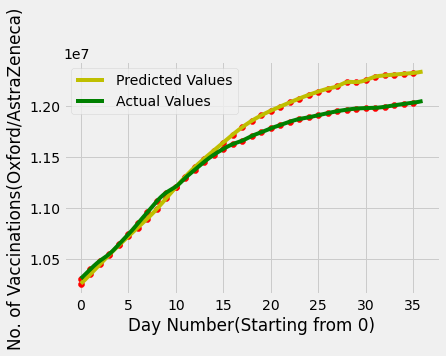

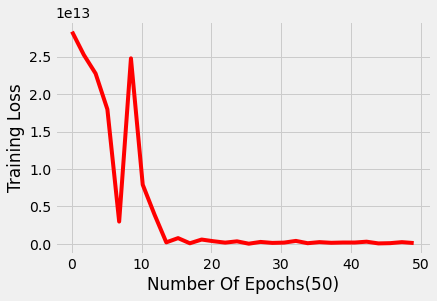

<Figure size 432x288 with 0 Axes>

In [20]:
f_ity_oxford = df.loc[df['location'] == 'Italy'].loc[df['vaccine'] == 'Oxford/AstraZeneca']

train, test = train_test_split(f_ity_oxford, test_size=0.2, shuffle=False)

print("Our Training Dataset looks like - ")
print(train.head(train.shape[0]))
print("Dimensions of our training dataset is : " + str(train.shape))
print('\n\n\n')
print("Our Testing Dataset looks like - ")
print(test.head(test.shape[0]))
print("Dimensions of our testing dataset is : " + str(test.shape))


total_vacc_ity_train = train.loc[:,"total_vaccinations"]
n_train =total_vacc_ity_train.values
#print(n_train)
#print(n_train.shape)


total_vacc_ity_test = test.loc[:,"total_vaccinations"]
n_test =total_vacc_ity_test.values
#print(n_test)
#print(n_test.shape)


# split a univariate sequence into samples (FOR TRAINING DATASET)
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
raw_seq = n_train
# choose a number of time steps
n_steps = 5
# split into samples
X_train, y_train = split_sequence(raw_seq, n_steps)
# summarize the data
#for i in range(len(X_train)):
#    print(X_train[i], y_train[i])

print('\n\n\n\n')
print("Dimensions of Training sequence : " + str(X_train.shape))


# define input sequence
raw_seq = n_test
# choose a number of time steps
n_steps = 5
# split into samples
X_test, y_test = split_sequence(raw_seq, n_steps)
# summarize the data
#for i in range(len(X3)):
#    print(X3[i], y3[i])
print("Dimensions of Testing sequence : " + str(X_test.shape))
print('\n\n\n\n')


# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))



model_rom_2 = Sequential()
model_rom_2.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model_rom_2.add(Dense(20))
model_rom_2.add(Dense(1))
model_rom_2.compile(optimizer='RMSprop', loss='mse',metrics=['accuracy'])

# fit model
history = model_rom_2.fit(X_train, y_train, epochs=50, verbose=0)

y_pred_train = model_rom_2.predict(X_train, verbose=0)
y_pred_test = model_rom_2.predict(X_test, verbose=0)

y_pred_train = y_pred_train.tolist()
y_pred_test = y_pred_test.tolist()

y_test = y_test.tolist()

y_ = []
for i in y_pred_test:
    y_.append(i[0])

merge = tuple(zip(y_,y_test))


acc = []
for i,j in merge:
    acc.append((abs(i-j)/j)*100)

print(acc)
    
a = np.array(acc).mean()
print("Average error percentage over all predictions = " + str(a))

g = X_test.shape[0]

x = [i for i in range(0,g)]

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.scatter(x,y_,color = 'r')
plt.scatter(x,y_test,color = 'r')
x_new = np.linspace(0,g,1000)
an = scipy.interpolate.make_interp_spline(x,y_)
an1 = scipy.interpolate.make_interp_spline(x,y_test)
y_new = an(x_new)
y_new1 = an1(x_new)
plt.plot(x_new, y_new,label = 'Predicted Values', color = 'y')
plt.plot(x_new, y_new1,label = 'Actual Values',color = 'g')
plt.legend()
plt.xlabel("Day Number(Starting from 0)")
plt.ylabel("No. of Vaccinations(Oxford/AstraZeneca)")
plt.figure()

acc = history.history['loss']
ep = range(len(acc))
x_new2 = np.linspace(0, 49, 30)
a_BSpline2 = interpolate.make_interp_spline(ep,acc)
y_new2 = a_BSpline2(x_new2)
plt.plot(x_new2,y_new2,'r', label='Training Loss' )
plt.xlabel("Number Of Epochs(50)")
plt.ylabel("Training Loss")
plt.figure()

#### 2.2 Manufacturer : Moderna

#### Training : Testing = 80:20 i.e. Training dataset = 65 days, Testing dataset = 17 days

Our Training Dataset looks like - 
     location        date  vaccine  total_vaccinations
5686    Italy  2021-01-06  Moderna                   1
5689    Italy  2021-01-08  Moderna                   3
5693    Italy  2021-01-11  Moderna                   8
5696    Italy  2021-01-13  Moderna                   9
5698    Italy  2021-01-14  Moderna                  95
...       ...         ...      ...                 ...
6265    Italy  2021-07-01  Moderna             5073267
6269    Italy  2021-07-02  Moderna             5125060
6273    Italy  2021-07-03  Moderna             5178084
6277    Italy  2021-07-04  Moderna             5218325
6281    Italy  2021-07-05  Moderna             5301047

[177 rows x 4 columns]
Dimensions of our training dataset is : (177, 4)




Our Testing Dataset looks like - 
     location        date  vaccine  total_vaccinations
6285    Italy  2021-07-06  Moderna             5375069
6289    Italy  2021-07-07  Moderna             5445600
6293    Italy  2021-07-08  Mo

<Figure size 432x288 with 0 Axes>

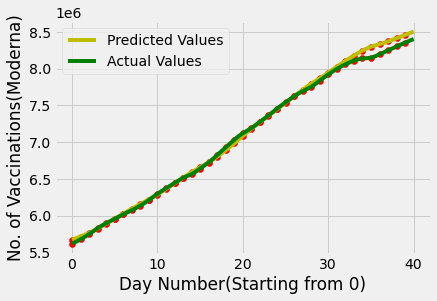

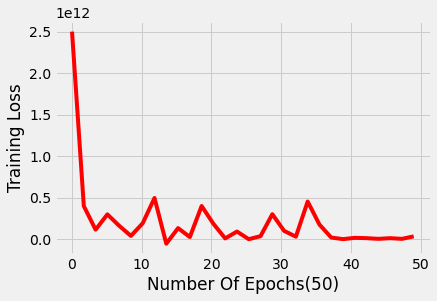

<Figure size 432x288 with 0 Axes>

In [19]:
f_ity_moderna = df.loc[df['location'] == 'Italy'].loc[df['vaccine'] == 'Moderna']

train, test = train_test_split(f_ity_moderna, test_size=0.2, shuffle=False)

print("Our Training Dataset looks like - ")
print(train.head(train.shape[0]))
print("Dimensions of our training dataset is : " + str(train.shape))
print('\n\n\n')
print("Our Testing Dataset looks like - ")
print(test.head(test.shape[0]))
print("Dimensions of our testing dataset is : " + str(test.shape))


total_vacc_ity_train = train.loc[:,"total_vaccinations"]
n_train =total_vacc_ity_train.values
#print(n_train)
#print(n_train.shape)


total_vacc_ity_test = test.loc[:,"total_vaccinations"]
n_test =total_vacc_ity_test.values
#print(n_test)
#print(n_test.shape)


# split a univariate sequence into samples (FOR TRAINING DATASET)
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
raw_seq = n_train
# choose a number of time steps
n_steps = 5
# split into samples
X_train, y_train = split_sequence(raw_seq, n_steps)
# summarize the data
#for i in range(len(X_train)):
#    print(X_train[i], y_train[i])

print('\n\n\n\n')
print("Dimensions of Training sequence : " + str(X_train.shape))


# define input sequence
raw_seq = n_test
# choose a number of time steps
n_steps = 5
# split into samples
X_test, y_test = split_sequence(raw_seq, n_steps)
# summarize the data
#for i in range(len(X3)):
#    print(X3[i], y3[i])
print("Dimensions of Testing sequence : " + str(X_test.shape))
print('\n\n\n\n')


# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))



model_rom_2 = Sequential()
model_rom_2.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model_rom_2.add(Dense(20))
model_rom_2.add(Dense(1))
model_rom_2.compile(optimizer='RMSprop', loss='mse',metrics=['accuracy'])

# fit model
history = model_rom_2.fit(X_train, y_train, epochs=50, verbose=0)

y_pred_train = model_rom_2.predict(X_train, verbose=0)
y_pred_test = model_rom_2.predict(X_test, verbose=0)

y_pred_train = y_pred_train.tolist()
y_pred_test = y_pred_test.tolist()

y_test = y_test.tolist()

y_ = []
for i in y_pred_test:
    y_.append(i[0])

merge = tuple(zip(y_,y_test))


acc = []
for i,j in merge:
    acc.append((abs(i-j)/j)*100)

print(acc)
    
a = np.array(acc).mean()
print("Average error percentage over all predictions = " + str(a))

g = X_test.shape[0]

x = [i for i in range(0,g)]

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.scatter(x,y_,color = 'r')
plt.scatter(x,y_test,color = 'r')
x_new = np.linspace(0,g,1000)
an = scipy.interpolate.make_interp_spline(x,y_)
an1 = scipy.interpolate.make_interp_spline(x,y_test)
y_new = an(x_new)
y_new1 = an1(x_new)
plt.plot(x_new, y_new,label = 'Predicted Values', color = 'y')
plt.plot(x_new, y_new1,label = 'Actual Values',color = 'g')
plt.legend()
plt.xlabel("Day Number(Starting from 0)")
plt.ylabel("No. of Vaccinations(Moderna)")
plt.figure()

acc = history.history['loss']
ep = range(len(acc))
x_new2 = np.linspace(0, 49, 30)
a_BSpline2 = interpolate.make_interp_spline(ep,acc)
y_new2 = a_BSpline2(x_new2)
plt.plot(x_new2,y_new2,'r', label='Training Loss' )
plt.xlabel("Number Of Epochs(50)")
plt.ylabel("Training Loss")
plt.figure()

#### 2.3 Manufacturer : Pfizer/BioNTech

#### Training : Testing = 80:20 i.e. Training dataset = 78 days, Testing dataset = 20 days

Our Training Dataset looks like - 
     location        date          vaccine  total_vaccinations
5675    Italy  2020-12-27  Pfizer/BioNTech                7247
5676    Italy  2020-12-28  Pfizer/BioNTech                8693
5677    Italy  2020-12-29  Pfizer/BioNTech                9722
5678    Italy  2020-12-30  Pfizer/BioNTech               14492
5679    Italy  2020-12-31  Pfizer/BioNTech               40152
...       ...         ...              ...                 ...
6255    Italy  2021-06-28  Pfizer/BioNTech            36026785
6259    Italy  2021-06-29  Pfizer/BioNTech            36415358
6263    Italy  2021-06-30  Pfizer/BioNTech            36809091
6267    Italy  2021-07-01  Pfizer/BioNTech            37236918
6271    Italy  2021-07-02  Pfizer/BioNTech            37649984

[188 rows x 4 columns]
Dimensions of our training dataset is : (188, 4)




Our Testing Dataset looks like - 
     location        date          vaccine  total_vaccinations
6275    Italy  2021-07-03  Pfizer/B

<Figure size 432x288 with 0 Axes>

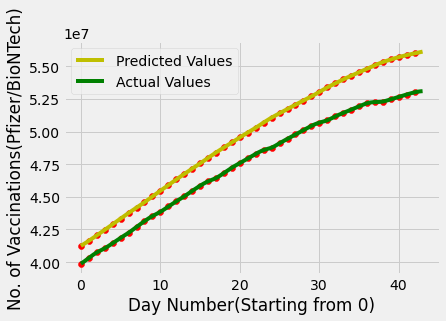

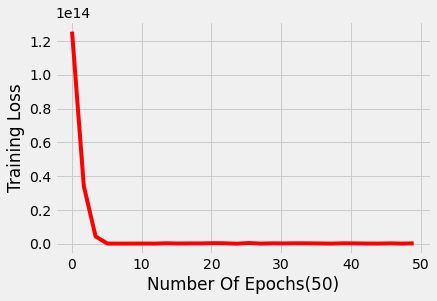

<Figure size 432x288 with 0 Axes>

In [23]:
f_ity_pfizer = df.loc[df['location'] == 'Italy'].loc[df['vaccine'] == 'Pfizer/BioNTech']

train, test = train_test_split(f_ity_pfizer, test_size=0.2, shuffle=False)

print("Our Training Dataset looks like - ")
print(train.head(train.shape[0]))
print("Dimensions of our training dataset is : " + str(train.shape))
print('\n\n\n')
print("Our Testing Dataset looks like - ")
print(test.head(test.shape[0]))
print("Dimensions of our testing dataset is : " + str(test.shape))


total_vacc_ity_train = train.loc[:,"total_vaccinations"]
n_train =total_vacc_ity_train.values
#print(n_train)
#print(n_train.shape)


total_vacc_ity_test = test.loc[:,"total_vaccinations"]
n_test =total_vacc_ity_test.values
#print(n_test)
#print(n_test.shape)


# split a univariate sequence into samples (FOR TRAINING DATASET)
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
raw_seq = n_train
# choose a number of time steps
n_steps = 5
# split into samples
X_train, y_train = split_sequence(raw_seq, n_steps)
# summarize the data
#for i in range(len(X_train)):
#    print(X_train[i], y_train[i])

print('\n\n\n\n')
print("Dimensions of Training sequence : " + str(X_train.shape))


# define input sequence
raw_seq = n_test
# choose a number of time steps
n_steps = 5
# split into samples
X_test, y_test = split_sequence(raw_seq, n_steps)
# summarize the data
#for i in range(len(X3)):
#    print(X3[i], y3[i])
print("Dimensions of Testing sequence : " + str(X_test.shape))
print('\n\n\n\n')


# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))



model_rom_2 = Sequential()
model_rom_2.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model_rom_2.add(Dense(20))
model_rom_2.add(Dense(1))
model_rom_2.compile(optimizer='RMSprop', loss='mse',metrics=['accuracy'])

# fit model
history = model_rom_2.fit(X_train, y_train, epochs=50, verbose=0)

y_pred_train = model_rom_2.predict(X_train, verbose=0)
y_pred_test = model_rom_2.predict(X_test, verbose=0)

y_pred_train = y_pred_train.tolist()
y_pred_test = y_pred_test.tolist()

y_test = y_test.tolist()

y_ = []
for i in y_pred_test:
    y_.append(i[0])

merge = tuple(zip(y_,y_test))


acc = []
for i,j in merge:
    acc.append((abs(i-j)/j)*100)

print(acc)
    
a = np.array(acc).mean()
print("Average error percentage over all predictions = " + str(a))

g = X_test.shape[0]

x = [i for i in range(0,g)]

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.scatter(x,y_,color = 'r')
plt.scatter(x,y_test,color = 'r')
x_new = np.linspace(0,g,1000)
an = scipy.interpolate.make_interp_spline(x,y_)
an1 = scipy.interpolate.make_interp_spline(x,y_test)
y_new = an(x_new)
y_new1 = an1(x_new)
plt.plot(x_new, y_new,label = 'Predicted Values', color = 'y')
plt.plot(x_new, y_new1,label = 'Actual Values',color = 'g')
plt.legend()
plt.xlabel("Day Number(Starting from 0)")
plt.ylabel("No. of Vaccinations(Pfizer/BioNTech)")
plt.figure()

acc = history.history['loss']
ep = range(len(acc))
x_new2 = np.linspace(0, 49, 30)
a_BSpline2 = interpolate.make_interp_spline(ep,acc)
y_new2 = a_BSpline2(x_new2)
plt.plot(x_new2,y_new2,'r', label='Training Loss' )
plt.xlabel("Number Of Epochs(50)")
plt.ylabel("Training Loss")
plt.figure()

### 3. Country : Germany

#### 3.1 Manufacturer : Pfizer/BioNTech

#### Training : Testing = 80:20 i.e. Training dataset = 77 days, Testing dataset = 20 days

Our Training Dataset looks like - 
     location        date          vaccine  total_vaccinations
3148  Germany  2020-12-27  Pfizer/BioNTech               24087
3152  Germany  2020-12-28  Pfizer/BioNTech               42078
3156  Germany  2020-12-29  Pfizer/BioNTech               92084
3160  Germany  2020-12-30  Pfizer/BioNTech              155579
3164  Germany  2020-12-31  Pfizer/BioNTech              205270
...       ...         ...              ...                 ...
3880  Germany  2021-06-28  Pfizer/BioNTech            53906438
3884  Germany  2021-06-29  Pfizer/BioNTech            54590673
3888  Germany  2021-06-30  Pfizer/BioNTech            55359594
3892  Germany  2021-07-01  Pfizer/BioNTech            56102920
3896  Germany  2021-07-02  Pfizer/BioNTech            56753322

[188 rows x 4 columns]
Dimensions of our training dataset is : (188, 4)




Our Testing Dataset looks like - 
     location        date          vaccine  total_vaccinations
3900  Germany  2021-07-03  Pfizer/B

<Figure size 432x288 with 0 Axes>

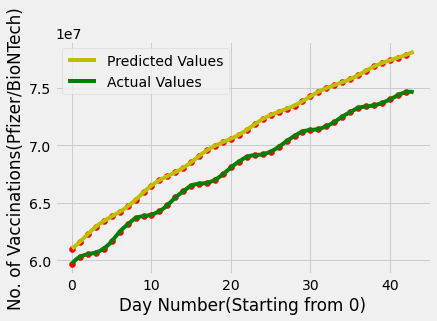

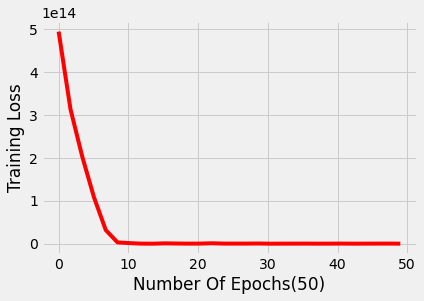

<Figure size 432x288 with 0 Axes>

In [24]:
f_ger_pfizer = df.loc[df['location'] == 'Germany'].loc[df['vaccine'] == 'Pfizer/BioNTech']

train, test = train_test_split(f_ger_pfizer, test_size=0.2, shuffle=False)

print("Our Training Dataset looks like - ")
print(train.head(train.shape[0]))
print("Dimensions of our training dataset is : " + str(train.shape))
print('\n\n\n')
print("Our Testing Dataset looks like - ")
print(test.head(test.shape[0]))
print("Dimensions of our testing dataset is : " + str(test.shape))


total_vacc_ger_train = train.loc[:,"total_vaccinations"]
n_train =total_vacc_ger_train.values
#print(n_train)
#print(n_train.shape)


total_vacc_ger_test = test.loc[:,"total_vaccinations"]
n_test =total_vacc_ger_test.values
#print(n_test)
#print(n_test.shape)


# split a univariate sequence into samples (FOR TRAINING DATASET)
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
raw_seq = n_train
# choose a number of time steps
n_steps = 5
# split into samples
X_train, y_train = split_sequence(raw_seq, n_steps)
# summarize the data
#for i in range(len(X_train)):
#    print(X_train[i], y_train[i])

print('\n\n\n\n')
print("Dimensions of Training sequence : " + str(X_train.shape))


# define input sequence
raw_seq = n_test
# choose a number of time steps
n_steps = 5
# split into samples
X_test, y_test = split_sequence(raw_seq, n_steps)
# summarize the data
#for i in range(len(X3)):
#    print(X3[i], y3[i])
print("Dimensions of Testing sequence : " + str(X_test.shape))
print('\n\n\n\n')


# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))



model_rom_2 = Sequential()
model_rom_2.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model_rom_2.add(Dense(20))
model_rom_2.add(Dense(1))
model_rom_2.compile(optimizer='RMSprop', loss='mse',metrics=['accuracy'])

# fit model
history = model_rom_2.fit(X_train, y_train, epochs=50, verbose=0)

y_pred_train = model_rom_2.predict(X_train, verbose=0)
y_pred_test = model_rom_2.predict(X_test, verbose=0)

y_pred_train = y_pred_train.tolist()
y_pred_test = y_pred_test.tolist()

y_test = y_test.tolist()

y_ = []
for i in y_pred_test:
    y_.append(i[0])

merge = tuple(zip(y_,y_test))


acc = []
for i,j in merge:
    acc.append((abs(i-j)/j)*100)

print(acc)
    
a = np.array(acc).mean()
print("Average error percentage over all predictions = " + str(a))

g = X_test.shape[0]

x = [i for i in range(0,g)]

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.scatter(x,y_,color = 'r')
plt.scatter(x,y_test,color = 'r')
x_new = np.linspace(0,g,1000)
an = scipy.interpolate.make_interp_spline(x,y_)
an1 = scipy.interpolate.make_interp_spline(x,y_test)
y_new = an(x_new)
y_new1 = an1(x_new)
plt.plot(x_new, y_new,label = 'Predicted Values', color = 'y')
plt.plot(x_new, y_new1,label = 'Actual Values',color = 'g')
plt.legend()
plt.xlabel("Day Number(Starting from 0)")
plt.ylabel("No. of Vaccinations(Pfizer/BioNTech)")
plt.figure()

acc = history.history['loss']
ep = range(len(acc))
x_new2 = np.linspace(0, 49, 30)
a_BSpline2 = interpolate.make_interp_spline(ep,acc)
y_new2 = a_BSpline2(x_new2)
plt.plot(x_new2,y_new2,'r', label='Training Loss' )
plt.xlabel("Number Of Epochs(50)")
plt.ylabel("Training Loss")
plt.figure()

#### 3.2 Manufacturer : Oxford/AstraZeneca

#### Training : Testing = 80:20 i.e. Training dataset = 67 days, Testing dataset = 30 days

Our Training Dataset looks like - 
     location        date             vaccine  total_vaccinations
3147  Germany  2020-12-27  Oxford/AstraZeneca                   0
3151  Germany  2020-12-28  Oxford/AstraZeneca                   0
3155  Germany  2020-12-29  Oxford/AstraZeneca                   1
3159  Germany  2020-12-30  Oxford/AstraZeneca                   1
3163  Germany  2020-12-31  Oxford/AstraZeneca                   1
...       ...         ...                 ...                 ...
3879  Germany  2021-06-28  Oxford/AstraZeneca            11305159
3883  Germany  2021-06-29  Oxford/AstraZeneca            11437892
3887  Germany  2021-06-30  Oxford/AstraZeneca            11574509
3891  Germany  2021-07-01  Oxford/AstraZeneca            11707317
3895  Germany  2021-07-02  Oxford/AstraZeneca            11786544

[188 rows x 4 columns]
Dimensions of our training dataset is : (188, 4)




Our Testing Dataset looks like - 
     location        date             vaccine  total_vaccinati

<Figure size 432x288 with 0 Axes>

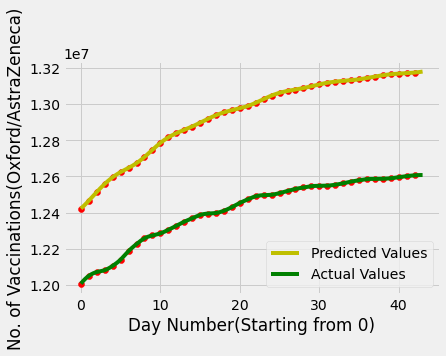

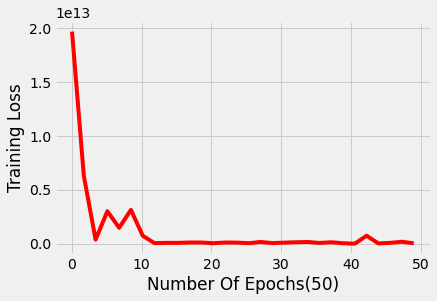

<Figure size 432x288 with 0 Axes>

In [27]:
f_ger_oxford = df.loc[df['location'] == 'Germany'].loc[df['vaccine'] == 'Oxford/AstraZeneca']

train, test = train_test_split(f_ger_oxford, test_size=0.2, shuffle=False)

print("Our Training Dataset looks like - ")
print(train.head(train.shape[0]))
print("Dimensions of our training dataset is : " + str(train.shape))
print('\n\n\n')
print("Our Testing Dataset looks like - ")
print(test.head(test.shape[0]))
print("Dimensions of our testing dataset is : " + str(test.shape))


total_vacc_ger_train = train.loc[:,"total_vaccinations"]
n_train =total_vacc_ger_train.values
#print(n_train)
#print(n_train.shape)


total_vacc_ger_test = test.loc[:,"total_vaccinations"]
n_test =total_vacc_ger_test.values
#print(n_test)
#print(n_test.shape)


# split a univariate sequence into samples (FOR TRAINING DATASET)
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
raw_seq = n_train
# choose a number of time steps
n_steps = 5
# split into samples
X_train, y_train = split_sequence(raw_seq, n_steps)
# summarize the data
#for i in range(len(X_train)):
#    print(X_train[i], y_train[i])

print('\n\n\n\n')
print("Dimensions of Training sequence : " + str(X_train.shape))


# define input sequence
raw_seq = n_test
# choose a number of time steps
n_steps = 5
# split into samples
X_test, y_test = split_sequence(raw_seq, n_steps)
# summarize the data
#for i in range(len(X3)):
#    print(X3[i], y3[i])
print("Dimensions of Testing sequence : " + str(X_test.shape))
print('\n\n\n\n')


# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))



model_rom_2 = Sequential()
model_rom_2.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model_rom_2.add(Dense(20))
model_rom_2.add(Dense(1))
model_rom_2.compile(optimizer='RMSprop', loss='mse',metrics=['accuracy'])

# fit model
history = model_rom_2.fit(X_train, y_train, epochs=50, verbose=0)

y_pred_train = model_rom_2.predict(X_train, verbose=0)
y_pred_test = model_rom_2.predict(X_test, verbose=0)

y_pred_train = y_pred_train.tolist()
y_pred_test = y_pred_test.tolist()

y_test = y_test.tolist()

y_ = []
for i in y_pred_test:
    y_.append(i[0])

merge = tuple(zip(y_,y_test))


acc = []
for i,j in merge:
    acc.append((abs(i-j)/j)*100)

print(acc)
    
a = np.array(acc).mean()
print("Average error percentage over all predictions = " + str(a))

g = X_test.shape[0]

x = [i for i in range(0,g)]

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.scatter(x,y_,color = 'r')
plt.scatter(x,y_test,color = 'r')
x_new = np.linspace(0,g,1000)
an = scipy.interpolate.make_interp_spline(x,y_)
an1 = scipy.interpolate.make_interp_spline(x,y_test)
y_new = an(x_new)
y_new1 = an1(x_new)
plt.plot(x_new, y_new,label = 'Predicted Values', color = 'y')
plt.plot(x_new, y_new1,label = 'Actual Values',color = 'g')
plt.legend()
plt.xlabel("Day Number(Starting from 0)")
plt.ylabel("No. of Vaccinations(Oxford/AstraZeneca)")
plt.figure()

acc = history.history['loss']
ep = range(len(acc))
x_new2 = np.linspace(0, 49, 30)
a_BSpline2 = interpolate.make_interp_spline(ep,acc)
y_new2 = a_BSpline2(x_new2)
plt.plot(x_new2,y_new2,'r', label='Training Loss' )
plt.xlabel("Number Of Epochs(50)")
plt.ylabel("Training Loss")
plt.figure()

#### 3.3 Manufacturer : Moderna

#### Training : Testing = 80:20 i.e. Training dataset = 77 days, Testing dataset = 20 days

Our Training Dataset looks like - 
     location        date  vaccine  total_vaccinations
3146  Germany  2020-12-27  Moderna                   2
3150  Germany  2020-12-28  Moderna                   2
3154  Germany  2020-12-29  Moderna                   2
3158  Germany  2020-12-30  Moderna                   2
3162  Germany  2020-12-31  Moderna                   2
...       ...         ...      ...                 ...
3878  Germany  2021-06-28  Moderna             6327604
3882  Germany  2021-06-29  Moderna             6420565
3886  Germany  2021-06-30  Moderna             6514713
3890  Germany  2021-07-01  Moderna             6598241
3894  Germany  2021-07-02  Moderna             6693232

[188 rows x 4 columns]
Dimensions of our training dataset is : (188, 4)




Our Testing Dataset looks like - 
     location        date  vaccine  total_vaccinations
3898  Germany  2021-07-03  Moderna             6772565
3902  Germany  2021-07-04  Moderna             6840722
3906  Germany  2021-07-05  Mo

<Figure size 432x288 with 0 Axes>

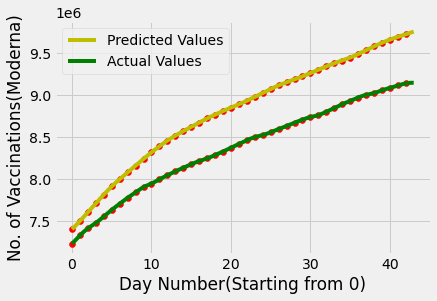

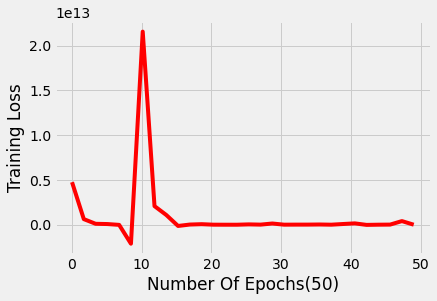

<Figure size 432x288 with 0 Axes>

In [32]:
f_ger_moderna = df.loc[df['location'] == 'Germany'].loc[df['vaccine'] == 'Moderna']

train, test = train_test_split(f_ger_moderna, test_size=0.2, shuffle=False)

print("Our Training Dataset looks like - ")
print(train.head(train.shape[0]))
print("Dimensions of our training dataset is : " + str(train.shape))
print('\n\n\n')
print("Our Testing Dataset looks like - ")
print(test.head(test.shape[0]))
print("Dimensions of our testing dataset is : " + str(test.shape))


total_vacc_ger_train = train.loc[:,"total_vaccinations"]
n_train =total_vacc_ger_train.values
#print(n_train)
#print(n_train.shape)


total_vacc_ger_test = test.loc[:,"total_vaccinations"]
n_test =total_vacc_ger_test.values
#print(n_test)
#print(n_test.shape)


# split a univariate sequence into samples (FOR TRAINING DATASET)
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
raw_seq = n_train
# choose a number of time steps
n_steps = 5
# split into samples
X_train, y_train = split_sequence(raw_seq, n_steps)
# summarize the data
#for i in range(len(X_train)):
#    print(X_train[i], y_train[i])

print('\n\n\n\n')
print("Dimensions of Training sequence : " + str(X_train.shape))


# define input sequence
raw_seq = n_test
# choose a number of time steps
n_steps = 5
# split into samples
X_test, y_test = split_sequence(raw_seq, n_steps)
# summarize the data
#for i in range(len(X3)):
#    print(X3[i], y3[i])
print("Dimensions of Testing sequence : " + str(X_test.shape))
print('\n\n\n\n')


# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))



model_rom_2 = Sequential()
model_rom_2.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model_rom_2.add(Dense(20))
model_rom_2.add(Dense(1))
model_rom_2.compile(optimizer='RMSprop', loss='mse',metrics=['accuracy'])

# fit model
history = model_rom_2.fit(X_train, y_train, epochs=50, verbose=0)

y_pred_train = model_rom_2.predict(X_train, verbose=0)
y_pred_test = model_rom_2.predict(X_test, verbose=0)

y_pred_train = y_pred_train.tolist()
y_pred_test = y_pred_test.tolist()

y_test = y_test.tolist()

y_ = []
for i in y_pred_test:
    y_.append(i[0])

merge = tuple(zip(y_,y_test))


acc = []
for i,j in merge:
    acc.append((abs(i-j)/j)*100)

print(acc)
    
a = np.array(acc).mean()
print("Average error percentage over all predictions = " + str(a))

g = X_test.shape[0]

x = [i for i in range(0,g)]

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.scatter(x,y_,color = 'r')
plt.scatter(x,y_test,color = 'r')
x_new = np.linspace(0,g,1000)
an = scipy.interpolate.make_interp_spline(x,y_)
an1 = scipy.interpolate.make_interp_spline(x,y_test)
y_new = an(x_new)
y_new1 = an1(x_new)
plt.plot(x_new, y_new,label = 'Predicted Values', color = 'y')
plt.plot(x_new, y_new1,label = 'Actual Values',color = 'g')
plt.legend()
plt.xlabel("Day Number(Starting from 0)")
plt.ylabel("No. of Vaccinations(Moderna)")
plt.figure()

acc = history.history['loss']
ep = range(len(acc))
x_new2 = np.linspace(0, 49, 30)
a_BSpline2 = interpolate.make_interp_spline(ep,acc)
y_new2 = a_BSpline2(x_new2)
plt.plot(x_new2,y_new2,'r', label='Training Loss' )
plt.xlabel("Number Of Epochs(50)")
plt.ylabel("Training Loss")
plt.figure()